No GPU found. Running on CPU.
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.7806 - loss: 0.4534 - val_accuracy: 1.0000 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 1.0000 - val_loss: 3.1962e-05 - learning_rate: 0.0010
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 1.0000 - loss: 7.9221e-04 - val_accuracy: 1.0000 - val_loss: 1.6589e-05 - learning_rate: 0.0010
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 3.9530e-05 
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 1.0000 - loss: 4.0827e-05 - val_accuracy: 1.0000 - val_loss: 8.9632e-06 - learning_rate: 0.0010
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 1.0000 - loss: 1.2985e-04 - val_accuracy: 1.0000 - val_loss: 8.8255e-06 - learning_rate: 2.0000e-04
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step

<Figure size 600x600 with 0 Axes>

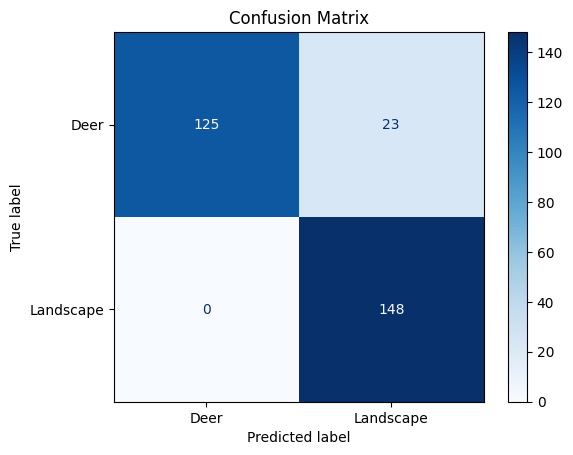

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import MobileNetV2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np
import random


random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Ensure TensorFlow is using the GPU if available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is being used.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found. Running on CPU.")

# Paths to dataset folders
base_dir = "C:\\Users\\Admin\\Desktop\\Image Processing"
train_dir = os.path.join(base_dir, "Deer train")
val_dir = os.path.join(base_dir, "Deer validate")
test_dir = os.path.join(base_dir, "Deer test")

# Parameters
img_size = (224, 224)  # MobileNetV2 standard input size
batch_size = 32
num_classes = 2
epochs = 10  # Adjust based on your dataset size and requirements

# Enable mixed precision for performance improvement
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Create a data pipeline for efficient data loading
def preprocess_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, img_size)
    image = image / 255.0  # Normalize
    return image, label

def create_dataset(directory, shuffle=False):
    class_names = sorted(os.listdir(directory))
    file_paths = []
    labels = []
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        for file in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, file))
            labels.append(class_idx)

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(file_paths))

    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset, class_names

# Load datasets using tf.data pipeline
train_dataset, class_names = create_dataset(train_dir, shuffle=True)  # Shuffle only training data
val_dataset, _ = create_dataset(val_dir, shuffle=False)  # No shuffling for validation
test_dataset, _ = create_dataset(test_dir, shuffle=False)  # No shuffling for test

# Load MobileNetV2 model pre-trained on ImageNet
base_model = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=img_size + (3,)
)

# Freeze the base model layers
base_model.trainable = False

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax", dtype='float32')
])

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Add early stopping and reduce LR on plateau
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)

# Train the model with early stopping
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr]
)

# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Recompile the model with a lower learning rate
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Fine-tuning with early stopping
history_fine_tune = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model on the test set and get the actual predictions
print("Evaluating model on test set...")

test_images, test_labels = [], []
for images, labels in test_dataset:
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

# Evaluate using the same test dataset
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Save the model
model.save("optimized_mobilenetv2_deer_classifier.keras")

# Generate predictions for the test set
predictions = model.predict(test_images, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Ensure the confusion matrix is based on the same test set used for evaluation
conf_matrix = confusion_matrix(test_labels, predicted_classes)

# Print classification report
print("Classification Report:")
print(classification_report(test_labels, predicted_classes, target_names=class_names))

# Plot confusion matrix
plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [2]:
import hashlib
import os

# Define dataset directories (same as in the main code)
base_dir = "C:\\Users\\Admin\\Desktop\\Image Processing"
train_dir = os.path.join(base_dir, "Deer train")
val_dir = os.path.join(base_dir, "Deer validate")
test_dir = os.path.join(base_dir, "Deer test")

def calculate_hash(image_path):
    """Calculate MD5 hash for a given image file."""
    with open(image_path, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

def check_duplicates(directories):
    """Check for duplicate images across the provided directories."""
    all_hashes = {}
    duplicates_found = False

    for directory in directories:
        for root, _, files in os.walk(directory):
            for file in files:
                file_path = os.path.join(root, file)
                file_hash = calculate_hash(file_path)

                if file_hash in all_hashes:
                    print(f"Duplicate found: {file_path} is a duplicate of {all_hashes[file_hash]}")
                    duplicates_found = True
                else:
                    all_hashes[file_hash] = file_path

    if not duplicates_found:
        print("No duplicate images found across the datasets.")

# Run duplicate check across train, validation, and test sets
check_duplicates([train_dir, val_dir, test_dir])



No duplicate images found across the datasets.


In [6]:
import tensorflow as tf
import os
import numpy as np

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Paths to dataset folders
base_dir = "C:\\Users\\Admin\\Desktop\\Image Processing"
train_dir = os.path.join(base_dir, "Deer train")
val_dir = os.path.join(base_dir, "Deer validate")
test_dir = os.path.join(base_dir, "Deer test")

# Parameters
img_size = (224, 224)
batch_size = 32

# Preprocessing function (same as used in the training pipeline)
def preprocess_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, img_size)
    image = image / 255.0  # Normalize
    return file_path, label  # Keep file_path for verification

# Dataset creation function (same as in the original training script)
def create_dataset(directory, shuffle=False):
    class_names = sorted(os.listdir(directory))
    file_paths = []
    labels = []
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        for file in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, file))
            labels.append(class_idx)

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(file_paths))

    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset, class_names, set(file_paths)

# Load datasets and keep track of file paths
print("Loading datasets for verification...")
train_dataset, class_names_train, train_files_used = create_dataset(train_dir, shuffle=True)
val_dataset, _, val_files_used = create_dataset(val_dir, shuffle=False)
test_dataset, _, test_files_used = create_dataset(test_dir, shuffle=False)

# Function to get filenames from directories
def get_filenames_from_directory(directory):
    filenames = set()
    for root, _, files in os.walk(directory):
        for file in files:
            filenames.add(os.path.join(root, file))
    return filenames

# Verify that all files used match those in directories
def verify_data_integrity(dataset_name, used_files, directory):
    expected_files = get_filenames_from_directory(directory)

    if used_files == expected_files:
        print(f"{dataset_name} data integrity verified: No missing or extra files.")
    else:
        missing_files = expected_files - used_files
        extra_files = used_files - expected_files
        if missing_files:
            print(f"Warning: The following expected files were not used in {dataset_name}:")
            print(missing_files)
        if extra_files:
            print(f"Warning: The following unexpected files were used in {dataset_name}:")
            print(extra_files)

# Perform verification checks
print("\nVerifying dataset integrity...\n")
verify_data_integrity("Training", train_files_used, train_dir)
verify_data_integrity("Validation", val_files_used, val_dir)
verify_data_integrity("Test", test_files_used, test_dir)

print("\nVerification completed.")


Loading datasets for verification...

Verifying dataset integrity...

Training data integrity verified: No missing or extra files.
Validation data integrity verified: No missing or extra files.
Test data integrity verified: No missing or extra files.

Verification completed.
